In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers 
from keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from PIL import Image
import random 

In [2]:
# for Manage loading, resizing, normalizing, and splitting images
class ImageDataLoader:
    def __init__(self, data_dir, img_size=(128, 128), train_test_split_ratio=0.2, random_seed=42):
        self.data_dir = data_dir
        self.pet_images_path = self.data_dir 
        self.img_size = img_size
        self.categories = ["Bear","Bird",'Cat','Cow',"Deer","Dog","Dolphin","Elephant","Giraffe","Horse","Kangaroo","Lion","Panda","Tiger","Zebra"] 
        self.train_data = []
        self.train_labels = []
        self.test_data = []
        self.test_labels = []
        self.train_test_split_ratio = train_test_split_ratio
        self.random_seed = random_seed
        random.seed(self.random_seed)
        np.random.seed(self.random_seed)

 # Core function to scan directories, load images, and assign labels (0 to 14)
    def load_and_preprocess_data(self):
        all_data = []
        all_labels = []
        pet_images_path = self.pet_images_path
        
        for i, category in enumerate(self.categories):
            path = os.path.join(pet_images_path, category)
            if not os.path.isdir(path):
                 print(f"Warning: Category directory not found: {path}")
                 continue
            # Loads image, converts to RGB, and resizes to 128x128     
            for img_file in os.listdir(path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(path, img_file)
                    try:
                        img = Image.open(img_path).convert('RGB').resize(self.img_size)
                        img_array = np.array(img) / 255.0
                        if img_array.shape == (self.img_size[0], self.img_size[1], 3):
                            all_data.append(img_array)
                            all_labels.append(i)
                    except Exception as e:
                        print(f"Error loading or processing image: {img_path} - {e}")

        # Shuffle and split data into training and testing set 
        combined = list(zip(all_data, all_labels))
        random.shuffle(combined)
        shuffled_data, shuffled_labels = zip(*combined)
        shuffled_data = np.array(shuffled_data)
        shuffled_labels = np.array(shuffled_labels)

        split_index = int(len(shuffled_data) * (1 - self.train_test_split_ratio))
        self.train_data = shuffled_data[:split_index]
        self.train_labels = shuffled_labels[:split_index]
        self.test_data = shuffled_data[split_index:]
        self.test_labels = shuffled_labels[split_index:]
        return self.train_data, self.train_labels, self.test_data, self.test_labels

In [3]:
# Model Building and Training, Defines the CNN architecture    
class ImageClassifierModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        # 1. Load MobileNetV2 base model
        base_model = MobileNetV2(weights='imagenet', 
                                 include_top=False, 
                                 input_shape=self.input_shape)
        
        # 2. Freeze the base layers
        base_model.trainable = False
        
        # 3. Build the new classification head
        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(), 
            layers.Dense(256, activation='relu'), 
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax') 
        ])
        return model

    def compile_model(self, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, x_train, y_train, epochs=20, validation_data=None):
        y_train = y_train.astype(np.int64)
        if validation_data:
            x_val, y_val = validation_data
            y_val = y_val.astype(np.int64)
            validation_data = (x_val, y_val)
            
        history = self.model.fit(x_train, y_train, epochs=epochs, validation_data=validation_data)
        return history
    
    # Evaluates the model's performance on unseen test data 
    def evaluate_model(self, x_test, y_test, verbose=0):
        y_test = y_test.astype(np.int64)
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=verbose)
        return loss, accuracy

    def predict(self, x):
        return self.model.predict(x)

Number of training samples: 1555
Number of testing samples: 389
Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.4717 - loss: 1.7992 - val_accuracy: 0.7481 - val_loss: 0.8495
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.7804 - loss: 0.7272 - val_accuracy: 0.7943 - val_loss: 0.6431
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.8448 - loss: 0.5063 - val_accuracy: 0.8149 - val_loss: 0.5884
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.8765 - loss: 0.3882 - val_accuracy: 0.8226 - val_loss: 0.5799
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.8988 - loss: 0.3191 - val_accuracy: 0.8355 - val_loss: 0.5718
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.9228 - loss: 0.2634 - val_accuracy: 0.8432 - val_loss: 0.4984
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.9202 - loss: 0.2428 - val_accuracy: 0.8586 - val_loss: 0.5055
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7

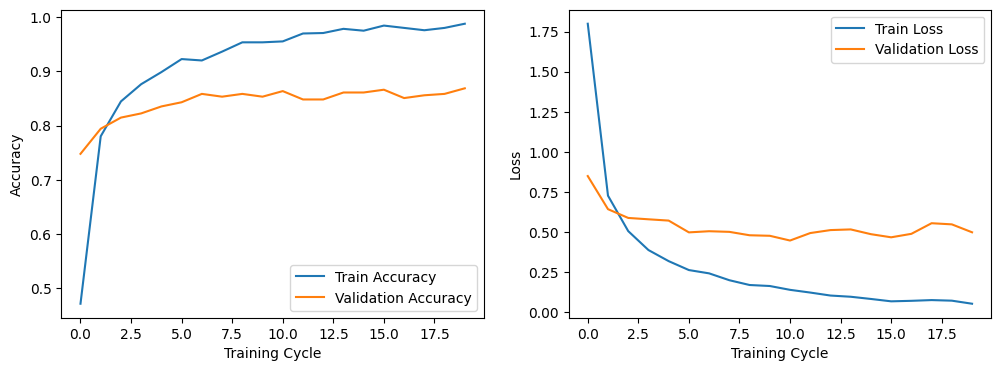

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step


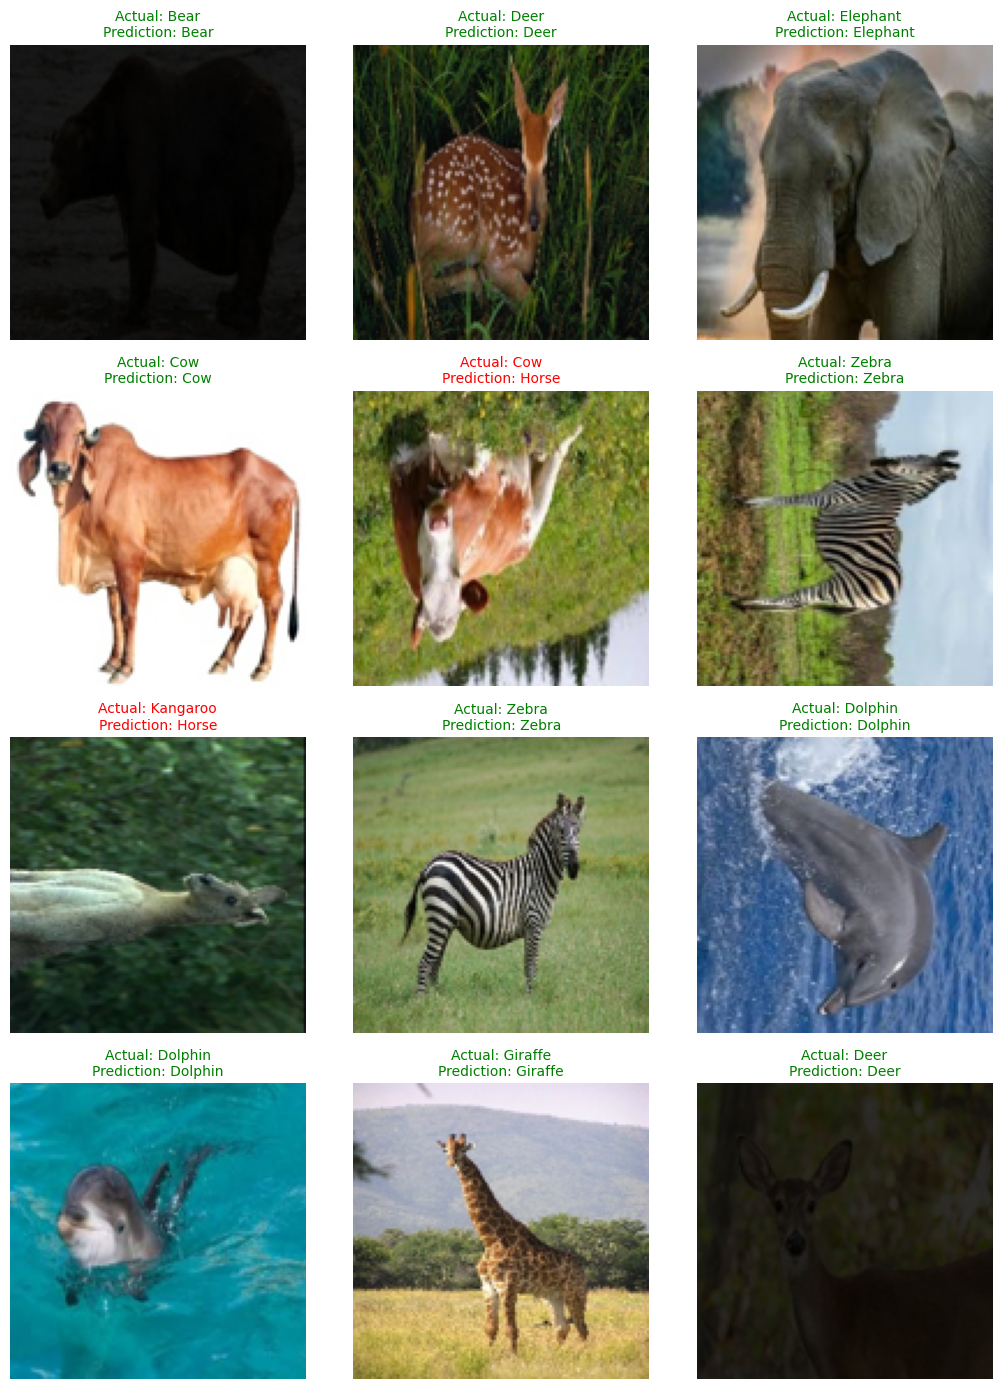

In [4]:
# Main execution Block        
if __name__ == "__main__":
    # --- Data Loading and Preprocessing ---
    data_dir = 'C:/Users/HP/Documents/animal_classification/data' 
    image_loader = ImageDataLoader(data_dir=data_dir, train_test_split_ratio=0.2)
    train_data, train_labels, test_data, test_labels = image_loader.load_and_preprocess_data()
    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of testing samples: {len(test_data)}")

    # Split the training data further into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.25, random_state=42) 

    # --- Model Building ---
    input_shape = (128, 128, 3)
    num_classes = len(image_loader.categories)
    model_builder = ImageClassifierModel(input_shape=input_shape, num_classes=num_classes)
    model_builder.compile_model(loss='sparse_categorical_crossentropy')

    # --- Model Training ---
    history = model_builder.train_model(X_train, y_train, epochs=20, validation_data=(X_val, y_val)) 

    # --- Model Evaluation ---
    loss, accuracy = model_builder.evaluate_model(test_data, test_labels)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # --- Results Visualization (Accuracy and Loss Plots) ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Training Cycle')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Training Cycle')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    # --- Making predictions on 12 RANDOM test images and visualizing ---
    num_display_images = 12
    total_test_samples = len(test_data)

    if total_test_samples < num_display_images:
        print(f"Not enough test samples ({total_test_samples}) to display {num_display_images} images. Displaying all available.")
        num_display_images = total_test_samples
        
    rng = np.random.RandomState()
    sample_indices = rng.choice(total_test_samples, size=num_display_images, replace=False)
    
    predictions = model_builder.predict(test_data)
    predicted_indices = np.argmax(predictions, axis=1)

    sampled_test_data = test_data[sample_indices]
    sampled_test_labels = test_labels[sample_indices]
    sampled_predicted_indices = predicted_indices[sample_indices]
    
    num_rows, num_cols = 4, 3 
    plt.figure(figsize=(3.5 * num_cols, 3.5 * num_rows))
    
    for i in range(num_display_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(sampled_test_data[i])
        actual_label = image_loader.categories[sampled_test_labels[i]]
        predicted_label = image_loader.categories[sampled_predicted_indices[i]]
        title_color = 'green' if actual_label == predicted_label else 'red'
        
        plt.title(f"Actual: {actual_label}\nPrediction: {predicted_label}", fontsize=10, color=title_color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()